In [1]:
import os
import json
import random
import torch
import numpy as np
import torch.nn as nn
import mplcyberpunk as mcy
from tqdm.auto import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap, Normalize

In [2]:
def load_task(task_path):
    with open(task_path, 'r') as f:
        task = json.load(f)
    return task

def visualize_task(task, title_prefix="Original", num_samples=None):
    if num_samples is not None:
        task = task[:num_samples]
    
    for idx, pair in enumerate(task):
        input_grid = np.array(pair["input"])
        output_grid = np.array(pair["output"])
        
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        cmap = ListedColormap([
            '#000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
            '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'
        ])
        norm = Normalize(vmin=0, vmax=9)

        axes[0].imshow(input_grid, cmap=cmap, norm=norm)
        axes[0].set_title(f"{title_prefix} Input {idx+1}")
        axes[1].imshow(output_grid, cmap=cmap, norm=norm)
        axes[1].set_title(f"{title_prefix} Output {idx+1}")

        for ax in axes:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

def plot_task(task):
    examples = task['train']
    n_examples = len(examples)
    cmap = ListedColormap([
        '#000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
        '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'
    ])
    norm = Normalize(vmin=0, vmax=9)
    fig, axes = plt.subplots(2, n_examples, figsize=(n_examples * 4, 8))
    for i, example in enumerate(examples):
        axes[0, i].imshow(example['input'], cmap=cmap, norm=norm)
        axes[1, i].imshow(example['output'], cmap=cmap, norm=norm)
        axes[0, i].axis('off')
        axes[1, i].axis('off')
    plt.show()

In [3]:
data_dir = './arc_data/ARC-AGI-master/data/'
training_dir = os.path.join(data_dir, 'training')
evaluation_dir = os.path.join(data_dir, 'evaluation')

val_split = 0.2
random_seed = 42
random.seed(random_seed)

def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

train_files = [os.path.join(training_dir, f) for f in os.listdir(training_dir) if f.endswith('.json')]
evaluation_files = [os.path.join(evaluation_dir, f) for f in os.listdir(evaluation_dir) if f.endswith('.json')]

random.shuffle(train_files)
train_files, val_files = train_test_split(train_files, test_size=val_split, random_state=random_seed)

def process_files(file_list, key='train'):
    dataset = []
    for file_path in file_list:
        data = load_json(file_path)
        for item in data[key]:
            dataset.append({
                'input': item['input'],
                'output': item['output']
            })
    return dataset

train_dataset = process_files(train_files, key='train')
val_dataset = process_files(val_files, key='train')
eval_dataset = process_files(evaluation_files, key='test')

output_dir = './arc_data/processed_data'
os.makedirs(output_dir, exist_ok=True)

with open(os.path.join(output_dir, 'train_dataset.json'), 'w') as f:
    json.dump(train_dataset, f, indent=4)

with open(os.path.join(output_dir, 'val_dataset.json'), 'w') as f:
    json.dump(val_dataset, f, indent=4)

with open(os.path.join(output_dir, 'eval_dataset.json'), 'w') as f:
    json.dump(eval_dataset, f, indent=4)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Evaluation samples: {len(eval_dataset)}")

Training samples: 1043
Validation samples: 259
Evaluation samples: 419


In [4]:
def pad_grid_uniform(grid, target_size=30, pad_value=10):
    rows, cols = len(grid), len(grid[0]) if grid else 0

    row_padding = (target_size - rows) // 2
    col_padding = (target_size - cols) // 2

    row_padding_extra = (target_size - rows) % 2
    col_padding_extra = (target_size - cols) % 2

    padded_grid = np.full((target_size, target_size), pad_value, dtype=int)

    padded_grid[
        row_padding : row_padding + rows, 
        col_padding : col_padding + cols
    ] = grid

    return padded_grid.tolist()

def pad_dataset_uniform(dataset, target_size=30, pad_value=10):
    padded_dataset = []
    for task in dataset:
        padded_task = {
            "input": pad_grid_uniform(task["input"], target_size, pad_value),
            "output": pad_grid_uniform(task["output"], target_size, pad_value)
        }
        padded_dataset.append(padded_task)
    return padded_dataset

output_dir = './arc_data/processed_data'

with open(os.path.join(output_dir, 'train_dataset.json'), 'r') as f:
    train_dataset = json.load(f)

with open(os.path.join(output_dir, 'val_dataset.json'), 'r') as f:
    val_dataset = json.load(f)

with open(os.path.join(output_dir, 'eval_dataset.json'), 'r') as f:
    eval_dataset = json.load(f)

padded_train_dataset = pad_dataset_uniform(train_dataset, target_size=30, pad_value=10)
padded_val_dataset = pad_dataset_uniform(val_dataset, target_size=30, pad_value=10)
padded_eval_dataset = pad_dataset_uniform(eval_dataset, target_size=30, pad_value=10)

with open(os.path.join(output_dir, 'padded_train_dataset.json'), 'w') as f:
    json.dump(padded_train_dataset, f, indent=4)

with open(os.path.join(output_dir, 'padded_val_dataset.json'), 'w') as f:
    json.dump(padded_val_dataset, f, indent=4)

with open(os.path.join(output_dir, 'padded_eval_dataset.json'), 'w') as f:
    json.dump(padded_eval_dataset, f, indent=4)

print("Padding complete!")
print(f"Padded Training samples: {len(padded_train_dataset)}")
print(f"Padded Validation samples: {len(padded_val_dataset)}")
print(f"Padded Evaluation samples: {len(padded_eval_dataset)}")

Padding complete!
Padded Training samples: 1043
Padded Validation samples: 259
Padded Evaluation samples: 419


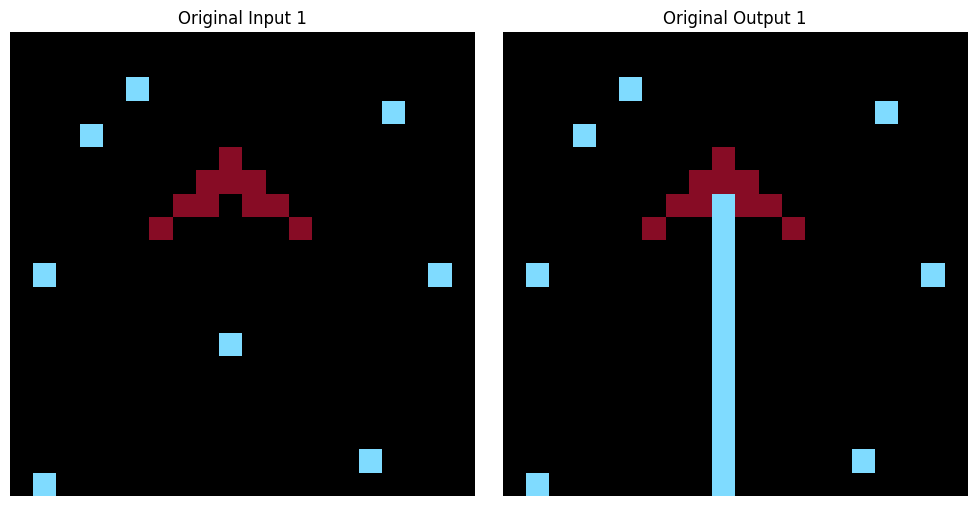

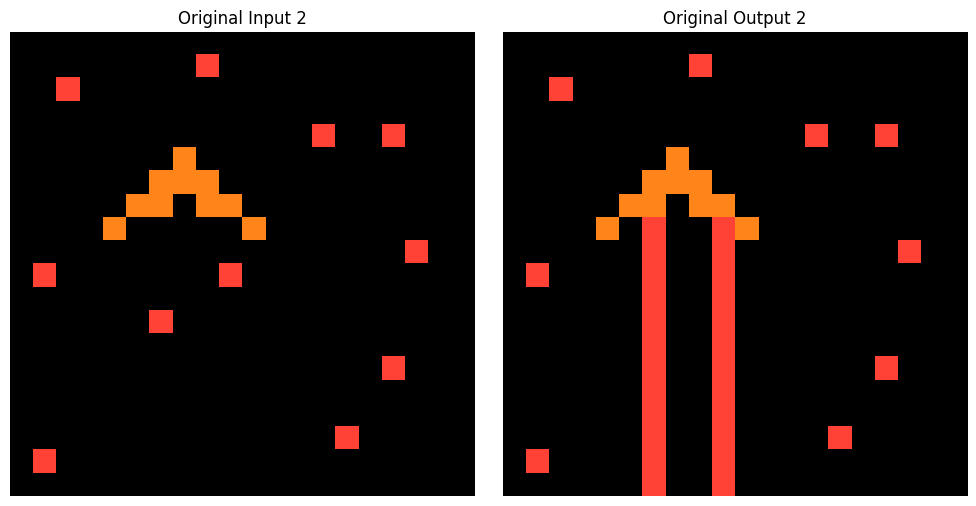

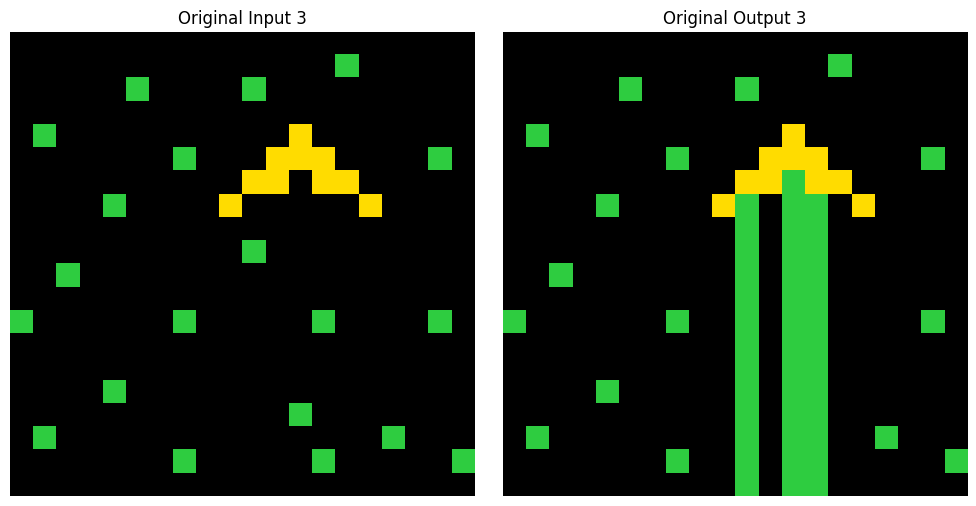

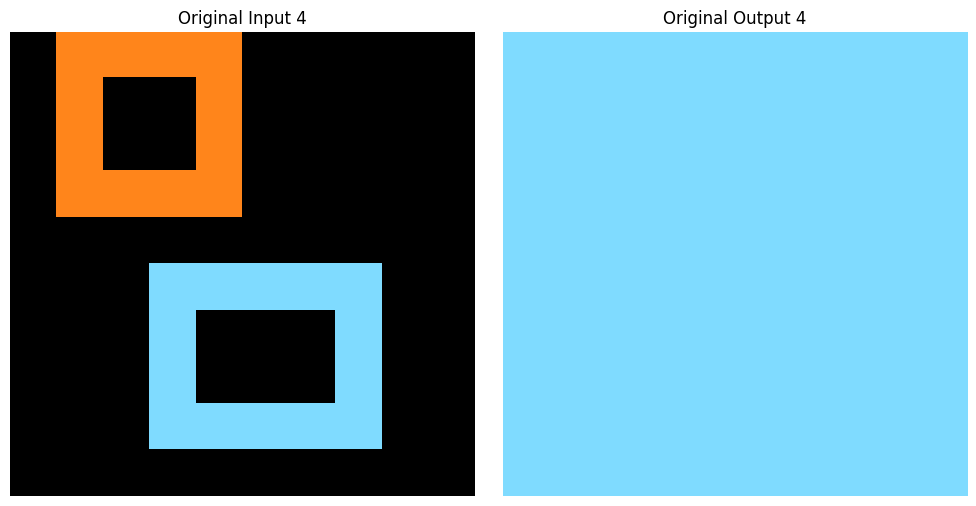

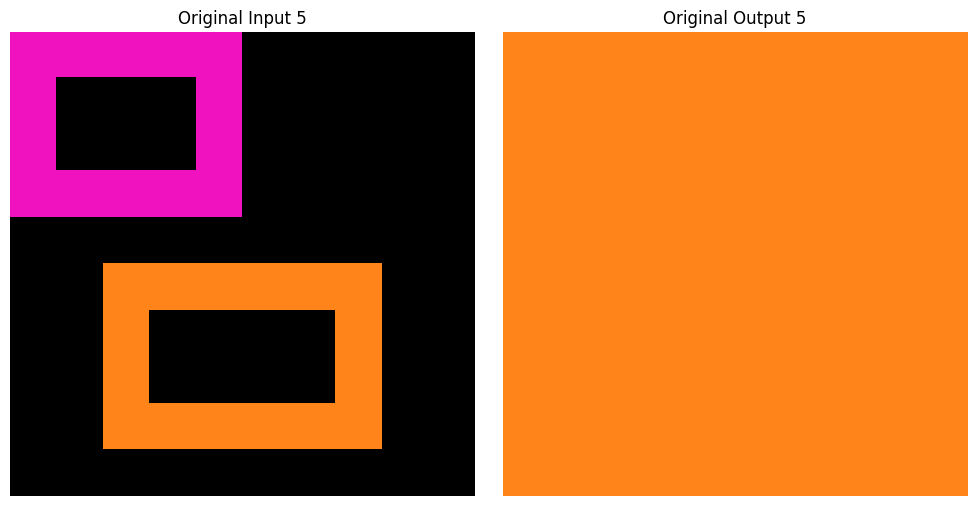

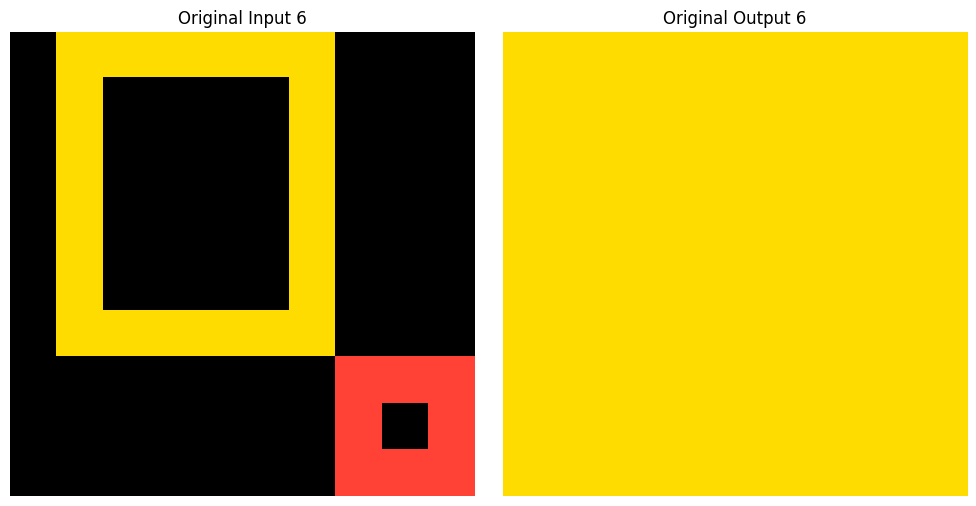

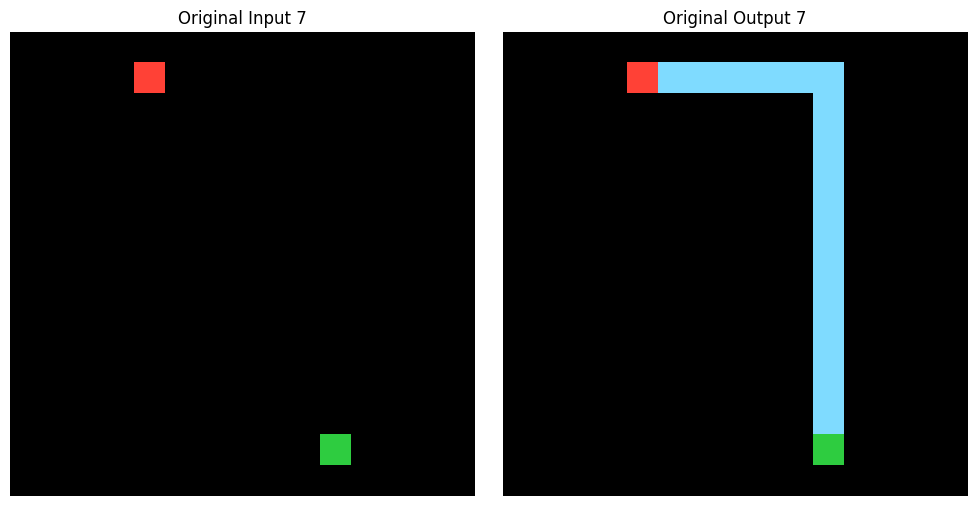

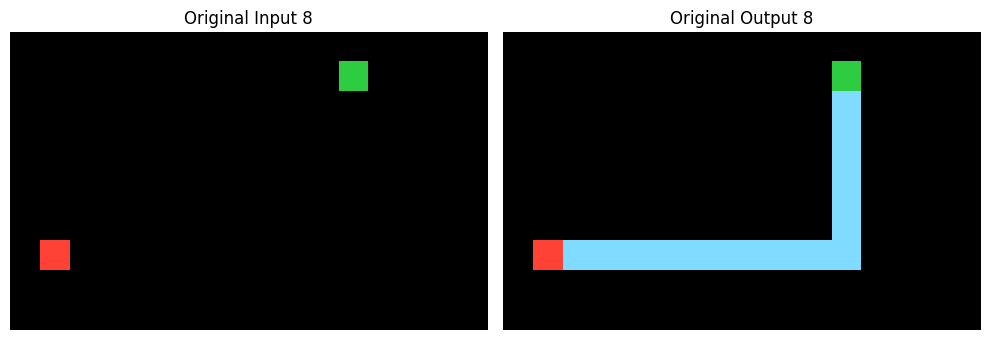

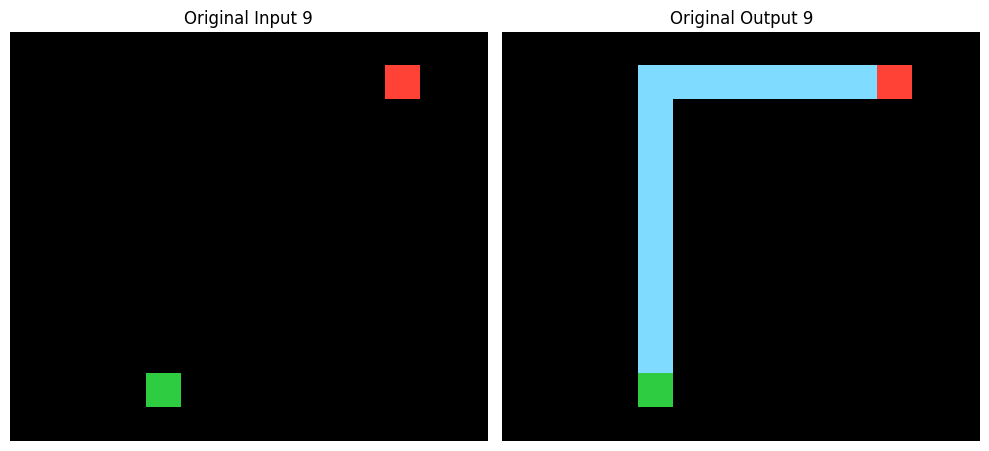

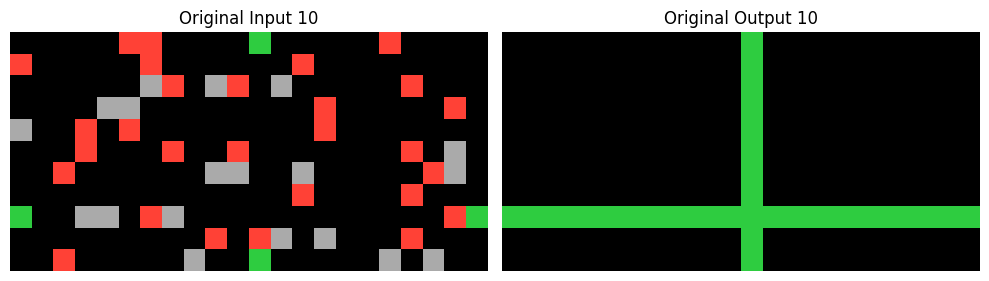

In [5]:
task_path = './arc_data/processed_data/train_dataset.json'
task = load_task(task_path)

visualize_task(task, title_prefix="Original", num_samples = 10)

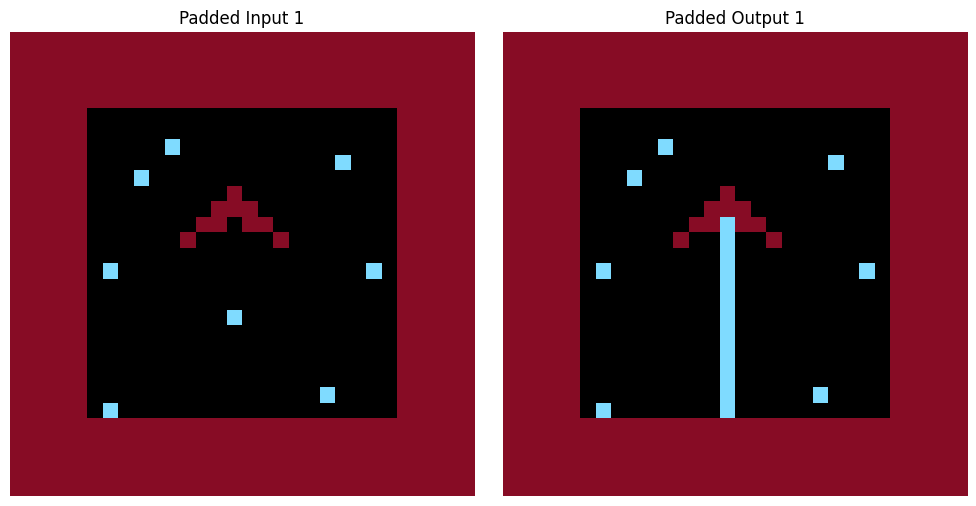

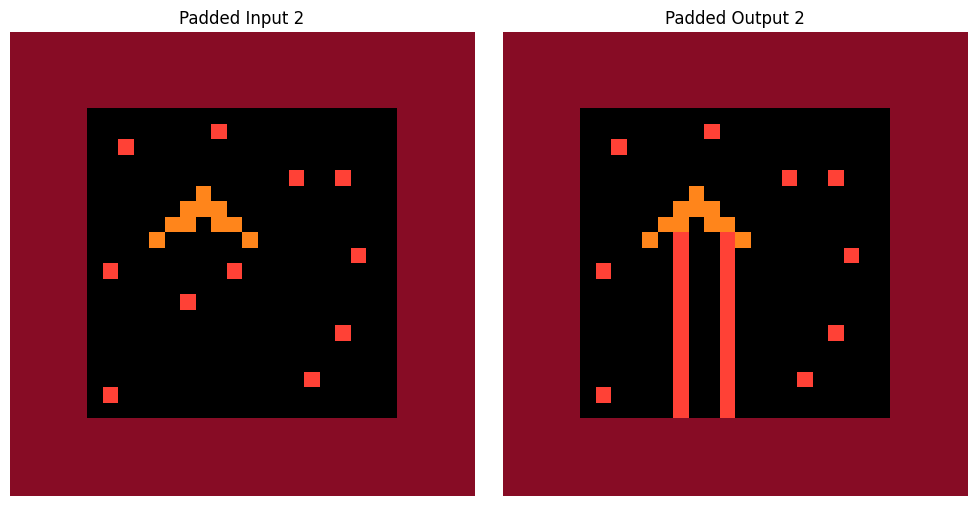

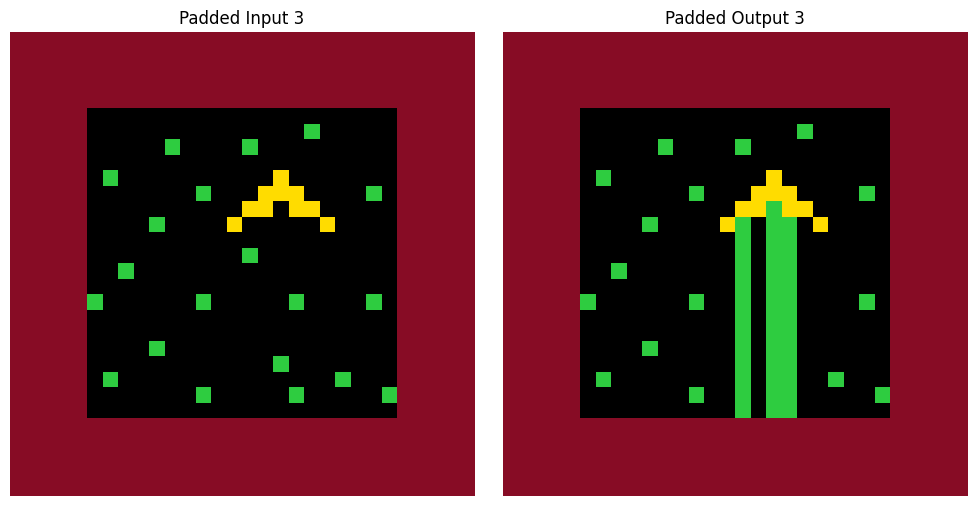

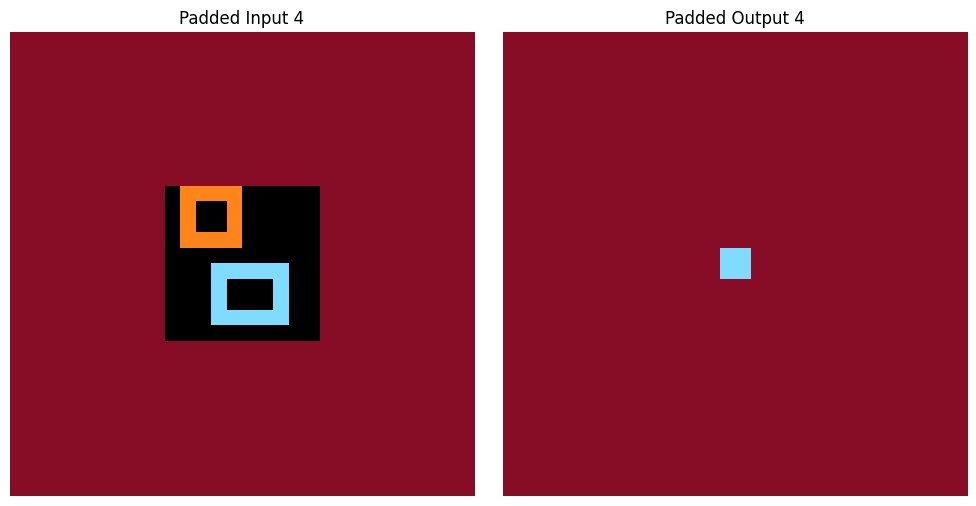

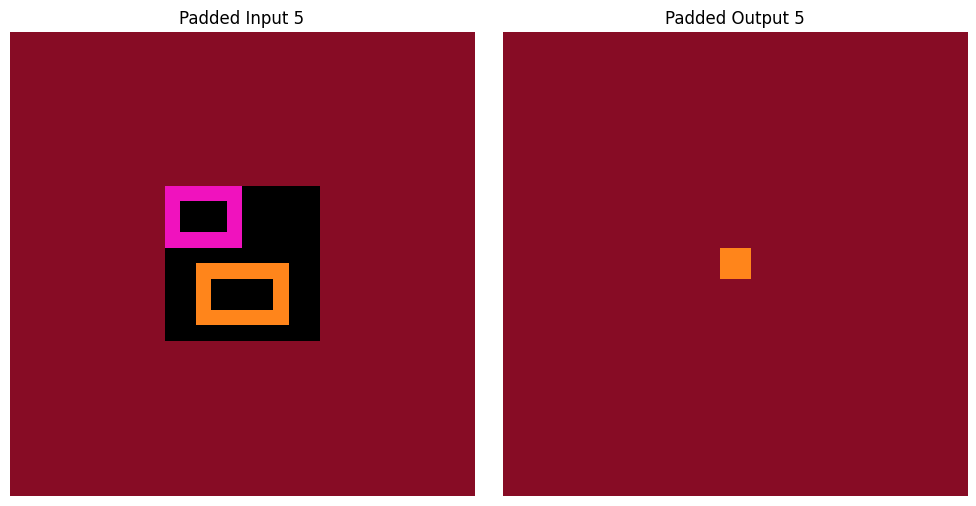

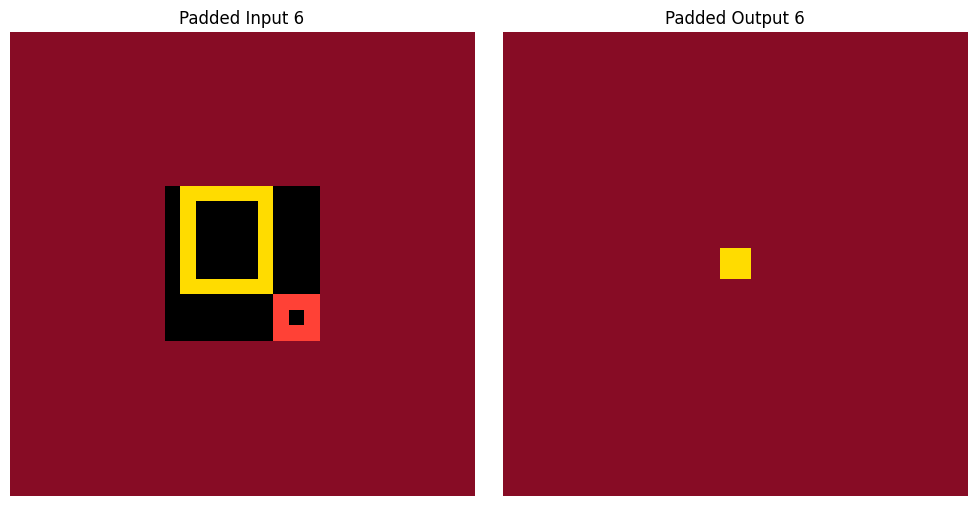

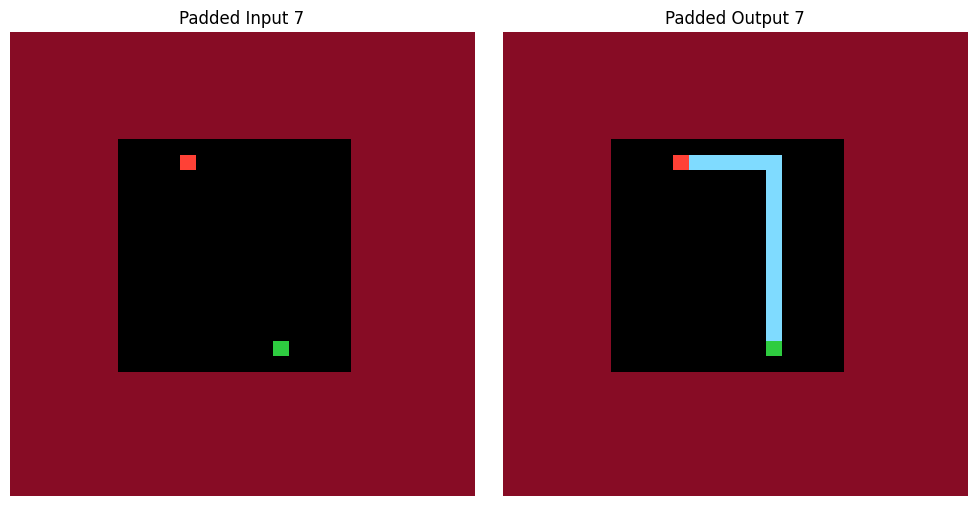

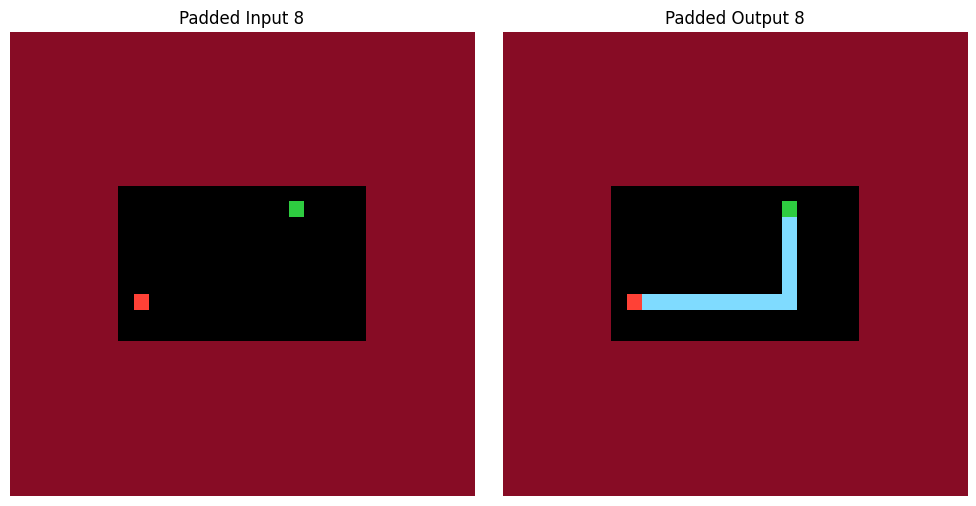

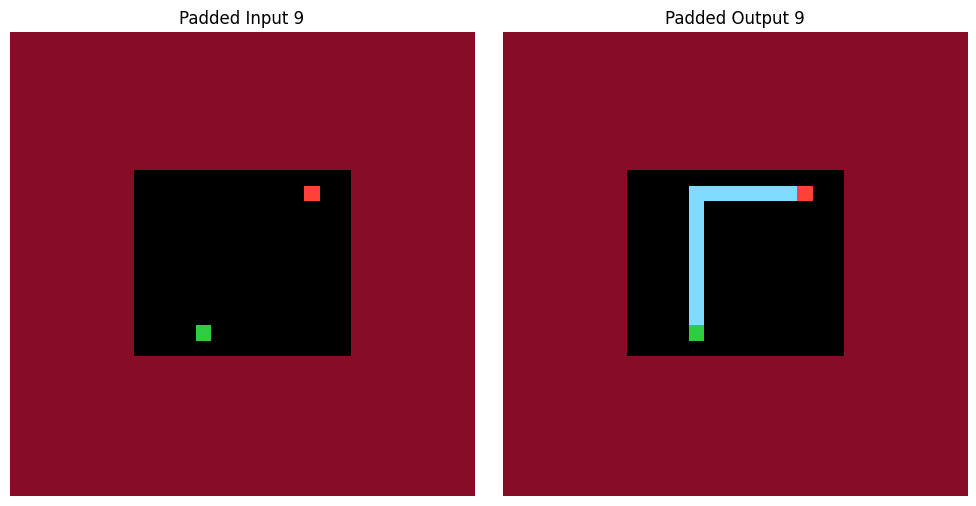

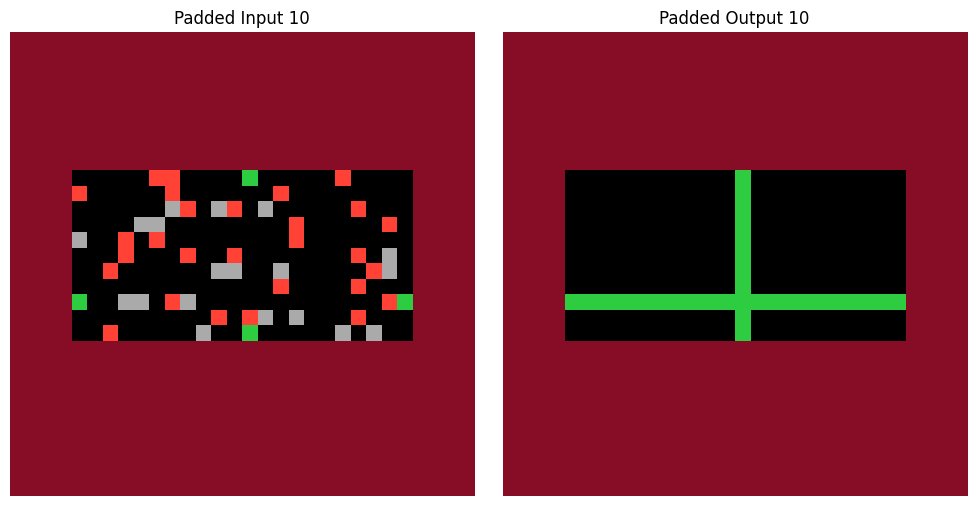

In [6]:
padded_task_path = './arc_data/processed_data/padded_train_dataset.json'
padded_task = load_task(padded_task_path)

visualize_task(padded_task, title_prefix="Padded", num_samples = 10)

In [7]:
def flatten_grid(grid):
    return [cell for row in grid for cell in row]

def flatten_dataset(dataset):
    flattened_dataset = []
    for task in dataset:
        flattened_task = {
            "input": flatten_grid(task["input"]),
            "output": flatten_grid(task["output"])
        }
        flattened_dataset.append(flattened_task)
    return flattened_dataset

flattened_train_dataset = flatten_dataset(padded_train_dataset)
flattened_val_dataset = flatten_dataset(padded_val_dataset)
flattened_eval_dataset = flatten_dataset(padded_eval_dataset)

output_dir = './arc_data/processed_data'

with open(os.path.join(output_dir, 'flattened_train_dataset.json'), 'w') as f:
    json.dump(flattened_train_dataset, f, indent=4)

with open(os.path.join(output_dir, 'flattened_val_dataset.json'), 'w') as f:
    json.dump(flattened_val_dataset, f, indent=4)

with open(os.path.join(output_dir, 'flattened_eval_dataset.json'), 'w') as f:
    json.dump(flattened_eval_dataset, f, indent=4)

print("Flattened datasets saved!")
print(f"Flattened Training samples: {len(flattened_train_dataset)}")
print(f"Flattened Validation samples: {len(flattened_val_dataset)}")
print(f"Flattened Evaluation samples: {len(flattened_eval_dataset)}")

Flattened datasets saved!
Flattened Training samples: 1043
Flattened Validation samples: 259
Flattened Evaluation samples: 419


In [8]:
BATCH_SIZE = 4
NUM_EPOCHS = 100
INNER_LR = 1e-4
OUTER_LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
class FlattenedARCDataset(Dataset):
    def __init__(self, data, is_input=True):
        self.data = data
        self.is_input = is_input

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.is_input:
            grid = self.data[idx]["input"]
        else:
            grid = self.data[idx]["output"]
        return torch.tensor(grid, dtype=torch.float32)

train_inputs = FlattenedARCDataset(flattened_train_dataset, is_input=True)
train_outputs = FlattenedARCDataset(flattened_train_dataset, is_input=False)

val_inputs = FlattenedARCDataset(flattened_val_dataset, is_input=True)
val_outputs = FlattenedARCDataset(flattened_val_dataset, is_input=False)

eval_inputs = FlattenedARCDataset(flattened_eval_dataset, is_input=True)
eval_outputs = FlattenedARCDataset(flattened_eval_dataset, is_input=False)

train_input_loader = DataLoader(train_inputs, batch_size=BATCH_SIZE, shuffle=True)
train_output_loader = DataLoader(train_outputs, batch_size=BATCH_SIZE, shuffle=True)

val_input_loader = DataLoader(val_inputs, batch_size=BATCH_SIZE, shuffle=False)
val_output_loader = DataLoader(val_outputs, batch_size=BATCH_SIZE, shuffle=False)

eval_input_loader = DataLoader(eval_inputs, batch_size=BATCH_SIZE, shuffle=False)
eval_output_loader = DataLoader(eval_outputs, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
class EncoderDecoderModel(nn.Module):
    def __init__(self, input_size=900, hidden_size=512, intermediate_size=256, encoded_size=128, num_heads=4, dropout_rate=0.3):
        super().__init__()

        self.encoder_fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(hidden_size, intermediate_size),
            nn.BatchNorm1d(intermediate_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(intermediate_size, encoded_size),
            nn.BatchNorm1d(encoded_size),
            nn.ReLU(),
        )
        
        self.encoder_attention = nn.MultiheadAttention(embed_dim=encoded_size, num_heads=num_heads, dropout=dropout_rate, batch_first=True)

        self.decoder_attention = nn.MultiheadAttention(embed_dim=encoded_size, num_heads=num_heads, dropout=dropout_rate, batch_first=True)
        
        self.decoder_fc = nn.Sequential(
            nn.Linear(encoded_size, intermediate_size),
            nn.BatchNorm1d(intermediate_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(intermediate_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), 1, -1)
        encoded_fc = self.encoder_fc(x.squeeze(1))
        encoded_fc = encoded_fc.unsqueeze(1)
        
        encoded, _ = self.encoder_attention(encoded_fc, encoded_fc, encoded_fc)
        decoded_attention, _ = self.decoder_attention(encoded, encoded, encoded)
        
        decoded_attention = decoded_attention.squeeze(1)
        decoded = self.decoder_fc(decoded_attention)
        
        return decoded

In [11]:
class MAMLTrainingPipeline:
    def __init__(self, model, train_input_loader, train_output_loader, val_input_loader, val_output_loader, outer_optimizer, device, inner_lr=INNER_LR):
        self.model = model
        self.train_input_loader = train_input_loader
        self.train_output_loader = train_output_loader
        self.val_input_loader = val_input_loader
        self.val_output_loader = val_output_loader
        self.outer_optimizer = outer_optimizer
        self.device = device
        self.inner_lr = inner_lr

    def compute_elementwise_loss(self, predicted, actual):
        differences = torch.abs(predicted - actual)
        total_loss = differences.sum()
        avg_loss = total_loss / predicted.numel()
        return avg_loss

    def inner_loop(self, inputs, targets):
        task_model = EncoderDecoderModel().to(self.device)
        task_model.load_state_dict(self.model.state_dict())
        inner_optimizer = optim.Adam(task_model.parameters(), lr=self.inner_lr)

        task_model.train()
        for _ in range(5):
            inner_optimizer.zero_grad()
            outputs = task_model(inputs)
            loss = self.compute_elementwise_loss(outputs, targets)
            loss.backward()
            inner_optimizer.step()

        return task_model

    def outer_loop(self, num_epochs):
        train_losses = []

        for epoch in tqdm(range(1, num_epochs + 1), desc="Meta-Training"):
            self.model.train()
            total_meta_loss = 0.0

            for inputs, targets in tqdm(zip(self.train_input_loader, self.train_output_loader), desc=f"Epoch {epoch} - Inner Loop", leave=False):
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                adapted_model = self.inner_loop(inputs, targets)

                adapted_model.eval()
                meta_outputs = adapted_model(inputs)
                meta_loss = self.compute_elementwise_loss(meta_outputs, targets)

                meta_loss.backward()
                total_meta_loss += meta_loss.item()

            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=5.0)
            self.outer_optimizer.step()
            self.outer_optimizer.zero_grad()

            train_losses.append(total_meta_loss / len(self.train_input_loader))
            print(f"Epoch {epoch}: Train Loss = {train_losses[-1]:.4f}")

            torch.save(self.model.state_dict(), f"meta_model_epoch_{epoch}.pth")

        print("Meta-Training completed. Computing final validation loss.")
        val_losses = self.validate()
        print(f"Final Validation Loss: {sum(val_losses) / len(val_losses):.4f}")

        torch.save(self.model.state_dict(), "best_meta_model.pth")
        print("Model saved as 'best_meta_model.pth'.")

        return train_losses, val_losses

    def validate(self):
        self.model.eval()
        batch_losses = []
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(zip(self.val_input_loader, self.val_output_loader), 1):
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.compute_elementwise_loss(outputs, targets)
                batch_losses.append(loss.item())
                print(f"Validation Batch {batch_idx}: Loss = {loss.item():.4f}")

        return batch_losses

In [12]:
model = EncoderDecoderModel().to(DEVICE)
outer_optimizer = optim.AdamW(model.parameters(), lr=OUTER_LR, weight_decay=0.01)

pipeline = MAMLTrainingPipeline(
    model,
    train_input_loader,
    train_output_loader,
    val_input_loader,
    val_output_loader,
    outer_optimizer,
    DEVICE
)

train_losses, val_losses = pipeline.outer_loop(num_epochs=NUM_EPOCHS)

Meta-Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1 - Inner Loop: 0it [00:00, ?it/s]

Epoch 1: Train Loss = 8.6164


Epoch 2 - Inner Loop: 0it [00:00, ?it/s]

Epoch 2: Train Loss = 8.6160


Epoch 3 - Inner Loop: 0it [00:00, ?it/s]

Epoch 3: Train Loss = 8.6152


Epoch 4 - Inner Loop: 0it [00:00, ?it/s]

Epoch 4: Train Loss = 8.6159


Epoch 5 - Inner Loop: 0it [00:00, ?it/s]

Epoch 5: Train Loss = 8.6158


Epoch 6 - Inner Loop: 0it [00:00, ?it/s]

Epoch 6: Train Loss = 8.6161


Epoch 7 - Inner Loop: 0it [00:00, ?it/s]

Epoch 7: Train Loss = 8.6164


Epoch 8 - Inner Loop: 0it [00:00, ?it/s]

Epoch 8: Train Loss = 8.6157


Epoch 9 - Inner Loop: 0it [00:00, ?it/s]

Epoch 9: Train Loss = 8.6152


Epoch 10 - Inner Loop: 0it [00:00, ?it/s]

Epoch 10: Train Loss = 8.6153


Epoch 11 - Inner Loop: 0it [00:00, ?it/s]

Epoch 11: Train Loss = 8.6155


Epoch 12 - Inner Loop: 0it [00:00, ?it/s]

Epoch 12: Train Loss = 8.6146


Epoch 13 - Inner Loop: 0it [00:00, ?it/s]

Epoch 13: Train Loss = 8.6154


Epoch 14 - Inner Loop: 0it [00:00, ?it/s]

Epoch 14: Train Loss = 8.6160


Epoch 15 - Inner Loop: 0it [00:00, ?it/s]

Epoch 15: Train Loss = 8.6148


Epoch 16 - Inner Loop: 0it [00:00, ?it/s]

Epoch 16: Train Loss = 8.6161


Epoch 17 - Inner Loop: 0it [00:00, ?it/s]

Epoch 17: Train Loss = 8.6154


Epoch 18 - Inner Loop: 0it [00:00, ?it/s]

Epoch 18: Train Loss = 8.6155


Epoch 19 - Inner Loop: 0it [00:00, ?it/s]

Epoch 19: Train Loss = 8.6162


Epoch 20 - Inner Loop: 0it [00:00, ?it/s]

Epoch 20: Train Loss = 8.6161


Epoch 21 - Inner Loop: 0it [00:00, ?it/s]

Epoch 21: Train Loss = 8.6145


Epoch 22 - Inner Loop: 0it [00:00, ?it/s]

Epoch 22: Train Loss = 8.6161


Epoch 23 - Inner Loop: 0it [00:00, ?it/s]

Epoch 23: Train Loss = 8.6144


Epoch 24 - Inner Loop: 0it [00:00, ?it/s]

Epoch 24: Train Loss = 8.6152


Epoch 25 - Inner Loop: 0it [00:00, ?it/s]

Epoch 25: Train Loss = 8.6147


Epoch 26 - Inner Loop: 0it [00:00, ?it/s]

Epoch 26: Train Loss = 8.6146


Epoch 27 - Inner Loop: 0it [00:00, ?it/s]

Epoch 27: Train Loss = 8.6163


Epoch 28 - Inner Loop: 0it [00:00, ?it/s]

Epoch 28: Train Loss = 8.6162


Epoch 29 - Inner Loop: 0it [00:00, ?it/s]

Epoch 29: Train Loss = 8.6151


Epoch 30 - Inner Loop: 0it [00:00, ?it/s]

Epoch 30: Train Loss = 8.6155


Epoch 31 - Inner Loop: 0it [00:00, ?it/s]

Epoch 31: Train Loss = 8.6159


Epoch 32 - Inner Loop: 0it [00:00, ?it/s]

Epoch 32: Train Loss = 8.6152


Epoch 33 - Inner Loop: 0it [00:00, ?it/s]

Epoch 33: Train Loss = 8.6157


Epoch 34 - Inner Loop: 0it [00:00, ?it/s]

Epoch 34: Train Loss = 8.6155


Epoch 35 - Inner Loop: 0it [00:00, ?it/s]

Epoch 35: Train Loss = 8.6161


Epoch 36 - Inner Loop: 0it [00:00, ?it/s]

Epoch 36: Train Loss = 8.6157


Epoch 37 - Inner Loop: 0it [00:00, ?it/s]

Epoch 37: Train Loss = 8.6152


Epoch 38 - Inner Loop: 0it [00:00, ?it/s]

Epoch 38: Train Loss = 8.6161


Epoch 39 - Inner Loop: 0it [00:00, ?it/s]

Epoch 39: Train Loss = 8.6162


Epoch 40 - Inner Loop: 0it [00:00, ?it/s]

Epoch 40: Train Loss = 8.6162


Epoch 41 - Inner Loop: 0it [00:00, ?it/s]

Epoch 41: Train Loss = 8.6154


Epoch 42 - Inner Loop: 0it [00:00, ?it/s]

Epoch 42: Train Loss = 8.6154


Epoch 43 - Inner Loop: 0it [00:00, ?it/s]

Epoch 43: Train Loss = 8.6154


Epoch 44 - Inner Loop: 0it [00:00, ?it/s]

Epoch 44: Train Loss = 8.6161


Epoch 45 - Inner Loop: 0it [00:00, ?it/s]

Epoch 45: Train Loss = 8.6157


Epoch 46 - Inner Loop: 0it [00:00, ?it/s]

Epoch 46: Train Loss = 8.6160


Epoch 47 - Inner Loop: 0it [00:00, ?it/s]

Epoch 47: Train Loss = 8.6162


Epoch 48 - Inner Loop: 0it [00:00, ?it/s]

Epoch 48: Train Loss = 8.6144


Epoch 49 - Inner Loop: 0it [00:00, ?it/s]

Epoch 49: Train Loss = 8.6159


Epoch 50 - Inner Loop: 0it [00:00, ?it/s]

Epoch 50: Train Loss = 8.6154


Epoch 51 - Inner Loop: 0it [00:00, ?it/s]

Epoch 51: Train Loss = 8.6150


Epoch 52 - Inner Loop: 0it [00:00, ?it/s]

Epoch 52: Train Loss = 8.6159


Epoch 53 - Inner Loop: 0it [00:00, ?it/s]

Epoch 53: Train Loss = 8.6154


Epoch 54 - Inner Loop: 0it [00:00, ?it/s]

Epoch 54: Train Loss = 8.6159


Epoch 55 - Inner Loop: 0it [00:00, ?it/s]

Epoch 55: Train Loss = 8.6153


Epoch 56 - Inner Loop: 0it [00:00, ?it/s]

Epoch 56: Train Loss = 8.6161


Epoch 57 - Inner Loop: 0it [00:00, ?it/s]

Epoch 57: Train Loss = 8.6159


Epoch 58 - Inner Loop: 0it [00:00, ?it/s]

Epoch 58: Train Loss = 8.6142


Epoch 59 - Inner Loop: 0it [00:00, ?it/s]

Epoch 59: Train Loss = 8.6159


Epoch 60 - Inner Loop: 0it [00:00, ?it/s]

Epoch 60: Train Loss = 8.6158


Epoch 61 - Inner Loop: 0it [00:00, ?it/s]

Epoch 61: Train Loss = 8.6155


Epoch 62 - Inner Loop: 0it [00:00, ?it/s]

Epoch 62: Train Loss = 8.6158


Epoch 63 - Inner Loop: 0it [00:00, ?it/s]

Epoch 63: Train Loss = 8.6160


Epoch 64 - Inner Loop: 0it [00:00, ?it/s]

Epoch 64: Train Loss = 8.6158


Epoch 65 - Inner Loop: 0it [00:00, ?it/s]

Epoch 65: Train Loss = 8.6160


Epoch 66 - Inner Loop: 0it [00:00, ?it/s]

Epoch 66: Train Loss = 8.6163


Epoch 67 - Inner Loop: 0it [00:00, ?it/s]

Epoch 67: Train Loss = 8.6156


Epoch 68 - Inner Loop: 0it [00:00, ?it/s]

Epoch 68: Train Loss = 8.6163


Epoch 69 - Inner Loop: 0it [00:00, ?it/s]

Epoch 69: Train Loss = 8.6143


Epoch 70 - Inner Loop: 0it [00:00, ?it/s]

Epoch 70: Train Loss = 8.6159


Epoch 71 - Inner Loop: 0it [00:00, ?it/s]

Epoch 71: Train Loss = 8.6146


Epoch 72 - Inner Loop: 0it [00:00, ?it/s]

Epoch 72: Train Loss = 8.6163


Epoch 73 - Inner Loop: 0it [00:00, ?it/s]

Epoch 73: Train Loss = 8.6157


Epoch 74 - Inner Loop: 0it [00:00, ?it/s]

Epoch 74: Train Loss = 8.6156


Epoch 75 - Inner Loop: 0it [00:00, ?it/s]

Epoch 75: Train Loss = 8.6161


Epoch 76 - Inner Loop: 0it [00:00, ?it/s]

Epoch 76: Train Loss = 8.6164


Epoch 77 - Inner Loop: 0it [00:00, ?it/s]

Epoch 77: Train Loss = 8.6161


Epoch 78 - Inner Loop: 0it [00:00, ?it/s]

Epoch 78: Train Loss = 8.6158


Epoch 79 - Inner Loop: 0it [00:00, ?it/s]

Epoch 79: Train Loss = 8.6157


Epoch 80 - Inner Loop: 0it [00:00, ?it/s]

Epoch 80: Train Loss = 8.6159


Epoch 81 - Inner Loop: 0it [00:00, ?it/s]

Epoch 81: Train Loss = 8.6159


Epoch 82 - Inner Loop: 0it [00:00, ?it/s]

Epoch 82: Train Loss = 8.6161


Epoch 83 - Inner Loop: 0it [00:00, ?it/s]

Epoch 83: Train Loss = 8.6160


Epoch 84 - Inner Loop: 0it [00:00, ?it/s]

Epoch 84: Train Loss = 8.6163


Epoch 85 - Inner Loop: 0it [00:00, ?it/s]

Epoch 85: Train Loss = 8.6155


Epoch 86 - Inner Loop: 0it [00:00, ?it/s]

Epoch 86: Train Loss = 8.6157


Epoch 87 - Inner Loop: 0it [00:00, ?it/s]

Epoch 87: Train Loss = 8.6159


Epoch 88 - Inner Loop: 0it [00:00, ?it/s]

Epoch 88: Train Loss = 8.6159


Epoch 89 - Inner Loop: 0it [00:00, ?it/s]

Epoch 89: Train Loss = 8.6159


Epoch 90 - Inner Loop: 0it [00:00, ?it/s]

Epoch 90: Train Loss = 8.6149


Epoch 91 - Inner Loop: 0it [00:00, ?it/s]

Epoch 91: Train Loss = 8.6163


Epoch 92 - Inner Loop: 0it [00:00, ?it/s]

Epoch 92: Train Loss = 8.6161


Epoch 93 - Inner Loop: 0it [00:00, ?it/s]

Epoch 93: Train Loss = 8.6159


Epoch 94 - Inner Loop: 0it [00:00, ?it/s]

Epoch 94: Train Loss = 8.6156


Epoch 95 - Inner Loop: 0it [00:00, ?it/s]

Epoch 95: Train Loss = 8.6154


Epoch 96 - Inner Loop: 0it [00:00, ?it/s]

Epoch 96: Train Loss = 8.6161


Epoch 97 - Inner Loop: 0it [00:00, ?it/s]

Epoch 97: Train Loss = 8.6158


Epoch 98 - Inner Loop: 0it [00:00, ?it/s]

Epoch 98: Train Loss = 8.6163


Epoch 99 - Inner Loop: 0it [00:00, ?it/s]

Epoch 99: Train Loss = 8.6144


Epoch 100 - Inner Loop: 0it [00:00, ?it/s]

Epoch 100: Train Loss = 8.6160
Meta-Training completed. Computing final validation loss.
Validation Batch 1: Loss = 9.2124
Validation Batch 2: Loss = 9.3265
Validation Batch 3: Loss = 8.7260
Validation Batch 4: Loss = 8.1771
Validation Batch 5: Loss = 8.4434
Validation Batch 6: Loss = 8.9035
Validation Batch 7: Loss = 8.7171
Validation Batch 8: Loss = 9.0982
Validation Batch 9: Loss = 9.0473
Validation Batch 10: Loss = 9.2657
Validation Batch 11: Loss = 8.5782
Validation Batch 12: Loss = 9.1585
Validation Batch 13: Loss = 8.8666
Validation Batch 14: Loss = 8.8781
Validation Batch 15: Loss = 8.3371
Validation Batch 16: Loss = 8.7227
Validation Batch 17: Loss = 9.3918
Validation Batch 18: Loss = 8.7760
Validation Batch 19: Loss = 6.3029
Validation Batch 20: Loss = 9.2221
Validation Batch 21: Loss = 9.4273
Validation Batch 22: Loss = 9.2701
Validation Batch 23: Loss = 9.0615
Validation Batch 24: Loss = 8.3371
Validation Batch 25: Loss = 8.4121
Validation Batch 26: Loss = 8.3445
Validation

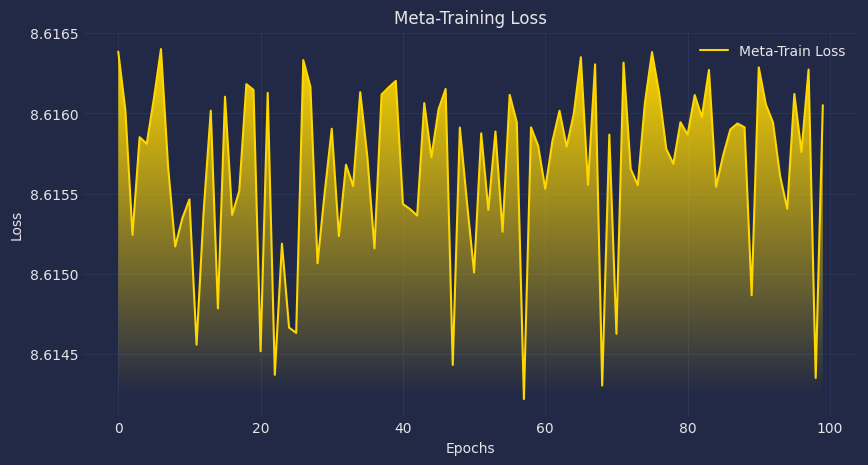

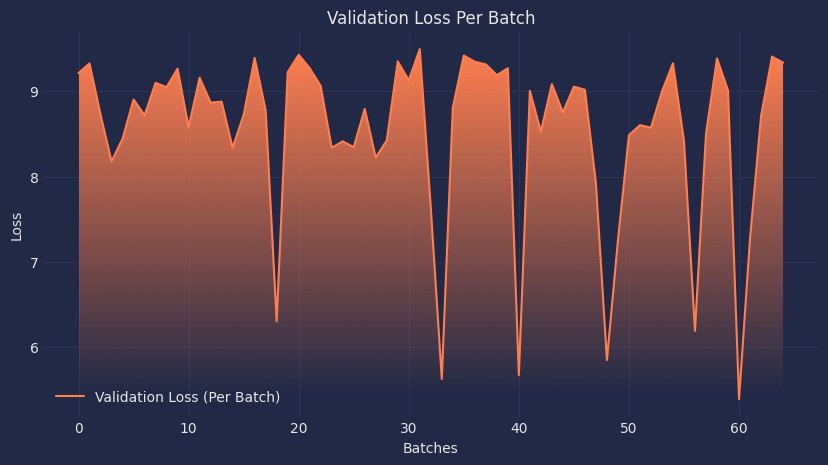

Meta-Training completed. Final Validation Loss: 8.5500


In [13]:
plt.style.use("cyberpunk")
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Meta-Train Loss", color="gold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Meta-Training Loss")
plt.legend()
mcy.add_gradient_fill()
plt.show()

plt.style.use("cyberpunk")
plt.figure(figsize=(10, 5))
plt.plot(val_losses, label="Validation Loss (Per Batch)", color="coral")
plt.xlabel("Batches")
plt.ylabel("Loss")
plt.title("Validation Loss Per Batch")
plt.legend()
mcy.add_gradient_fill()
plt.show()

print(f"Meta-Training completed. Final Validation Loss: {sum(val_losses) / len(val_losses):.4f}")

In [14]:
def strict_match_evaluation(model, input_loader, output_loader, device):
    model.eval()
    strict_matches = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, targets in tqdm(zip(input_loader, output_loader), desc="Strict Match Evaluation"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            predicted_outputs = torch.round(outputs).cpu().numpy()
            target_outputs = targets.cpu().numpy()

            for predicted, target in zip(predicted_outputs, target_outputs):
                if np.array_equal(predicted, target):
                    strict_matches += 1
                total_samples += 1

    accuracy = (strict_matches / total_samples) * 100
    print(f"Strict Match Accuracy: {accuracy:.2f}% ({strict_matches}/{total_samples})")
    return accuracy

model.load_state_dict(torch.load("best_meta_model.pth"))
model.to(DEVICE)

strict_match_accuracy = strict_match_evaluation(model, eval_input_loader, eval_output_loader, DEVICE)

Strict Match Evaluation: 0it [00:00, ?it/s]

Strict Match Accuracy: 0.00% (0/419)
